# Q3 Gaussian Mixture Models

## 3.1 Implement the GMM Class

### Import necessary libraries

In [1]:
import numpy as np
import hashlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.patches import Ellipse
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [2]:
# Using SHA-256 to generate unique seed
# username = "m.samartha"
# seed = int( hashlib.sha256(username.encode()).hexdigest(),16) % (2**32)+3
# print(seed)
seed = 62

### Multivariate Normal PDF

In [3]:
def multivariate_normal_pdf(X: np.ndarray, mean: np.ndarray, cov: np.ndarray) -> np.ndarray:
    """
    Compute the PDF of a multivariate normal distribution.

    X : np.ndarray
        Input data points of shape (n, d) where
        n = number of samples, d = dimension.
    mean : np.ndarray
        Mean vector of shape (d,).
    cov : np.ndarray
        Covariance matrix of shape (d, d).
    
    Returns
    -------
    pdf_values : np.ndarray
        PDF values for each sample, shape (n,).
    """
    X = np.atleast_2d(X)
    mean = np.asarray(mean)
    cov = np.asarray(cov)

    n, d = X.shape

    # Regularize covariance
    eps = 1e-6
    cov_reg = cov + eps * np.eye(cov.shape[0])

    cov_inv = np.linalg.inv(cov_reg)
    cov_det = np.linalg.det(cov_reg)

    # Handle potential negative/zero det due to numerical issues
    if cov_det <= 0:
        cov_det = eps  

    norm_const = 1.0 / np.sqrt((2 * np.pi) ** d * cov_det)

    # Centered data
    diff = X - mean
    exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)

    return norm_const * np.exp(exponent)

### GMM Class

In [4]:
class GMM:
    """
    Gaussian Mixture Model (GMM) implemented using the Expectation-Maximization (EM) algorithm.
    """

    def __init__(self, n_components=2, max_iters=100, tol=1e-6, random_state=None):
        """
        Initialize the GMM model.
        
        n_components : int
            Number of Gaussian components (clusters).
        max_iters : int
            Maximum number of iterations for EM.
        tol : float
            Convergence threshold for log-likelihood.
        random_state : int or None
            Random seed for reproducibility.
        """
        self.n_components = n_components
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state

        # Parameters to be learned
        self.means = None
        self.covariances = None
        self.weights = None

        # For storing likelihood progression
        self.likelihoods = []

    def initialize_parameters(self, X):
        """
        Initialize parameters (means, covariances, weights).
        """
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Randomly choose initial means from data points
        rand_idx = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[rand_idx]

        # Initialize covariances as identity matrices
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])

        # Initialize weights uniformly
        self.weights = np.ones(self.n_components) / self.n_components

    def e_step(self, X):
        """
        E-step: Compute responsibilities (membership probabilities).
        """
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * multivariate_normal_pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )

        # Normalize responsibilities
        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities /= np.clip(responsibilities_sum, 1e-12, None)
        
        return responsibilities

    def m_step(self, X, responsibilities):
        """
        M-step: Update parameters (weights, means, covariances).
        """
        n_samples, n_features = X.shape

        # Effective number of points assigned to each cluster
        Nk = responsibilities.sum(axis=0)  

        # Update weights
        self.weights = Nk / n_samples

        # Update means
        self.means = (responsibilities.T @ X) / Nk[:, np.newaxis]

        # Update covariances
        self.covariances = np.zeros((self.n_components, n_features, n_features))
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covariances[k] = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / Nk[k]

    def compute_likelihood(self, X):
        """
        Compute the overall log-likelihood of the dataset under current parameters.
        """
        likelihood = np.zeros(X.shape[0])
        for k in range(self.n_components):
            likelihood += self.weights[k] * multivariate_normal_pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )
        eps = 1e-12  # small constant to avoid log(0)
        return np.sum(np.log(np.clip(likelihood, eps, None)))

    def fit(self, X):
        """
        Fit the GMM model using the EM algorithm.
        
        X : ndarray of shape (n_samples, n_features)
            Input dataset.
        """
        self.initialize_parameters(X)

        for _ in range(self.max_iters):
            # E-step
            responsibilities = self.e_step(X)

            # M-step
            self.m_step(X, responsibilities)

            # Compute log-likelihood
            log_likelihood = self.compute_likelihood(X)
            self.likelihoods.append(log_likelihood)

            # Check convergence
            if len(self.likelihoods) > 1 and abs(self.likelihoods[-1] - self.likelihoods[-2]) < self.tol:
                break

    def getMembership(self, X):
        """
        Return the membership (responsibility) values for each sample.
        
        X : ndarray of shape (n_samples, n_features)
            Input dataset.
        
        Returns
        -------
        responsibilities : ndarray of shape (n_samples, n_components)
            Membership values for each sample.
        """
        return self.e_step(X)

    def getLikelihood(self):
        """
        Return the overall likelihood values stored during training.
        
        Returns
        -------
        likelihoods : list
            Log-likelihood values over iterations.
        """
        return self.likelihoods

    def drawLikelihood(self):
        """
        Plot likelihood vs iterations.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.likelihoods, marker='o')
        plt.title("Log-Likelihood vs Iterations", fontsize=16)
        plt.xlabel("Iteration", fontsize=14)
        plt.ylabel("Log-Likelihood", fontsize=14)
        plt.grid(True)
        plt.text(
            0.95, 0.95, "m.samartha",
            ha='right', va='top',
            transform=plt.gca().transAxes,
            fontsize=10, color='gray', alpha=0.7
        )
        plt.show()

### Load and Preprocess the Data

In [5]:
df = pd.read_csv("Dataset/Clustering_dataset.csv")
print("Dataset shape:", df.shape)
df.describe()

# Drop CustomerID (not useful for clustering)
df = df.drop(columns=["CustomerID"])

# Drop rows if any of the collumns have missing values
df = df.dropna()
print("Dataset shape after dropping missing values:", df.shape, "\n")

# Encode categorical "Genre"
label_encoder = LabelEncoder()
df["Genre"] = label_encoder.fit_transform(df["Genre"])  # Male=1, Female=0

Dataset shape: (200, 5)
Dataset shape after dropping missing values: (178, 4) 



### Applt GMM to the Data

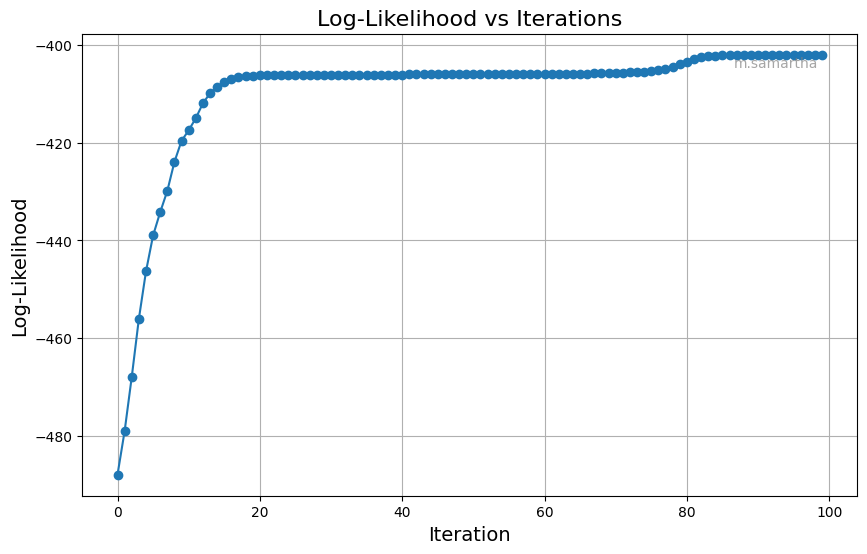

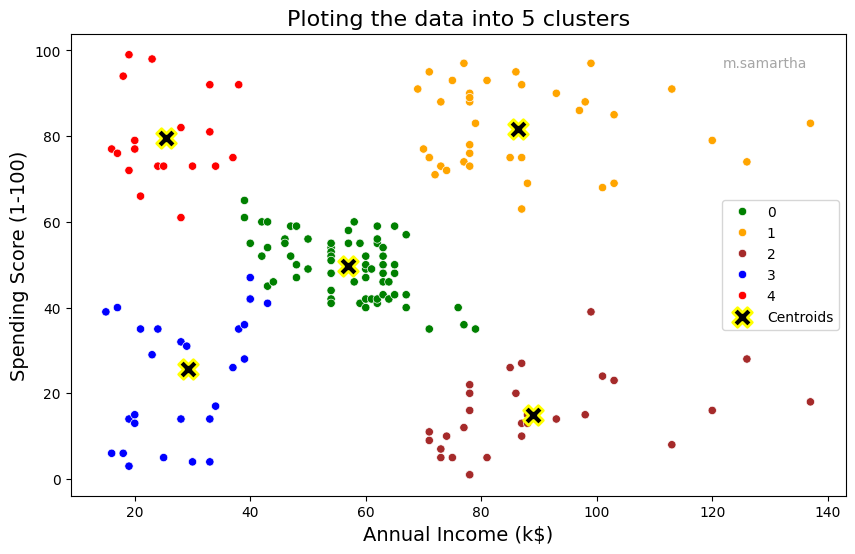

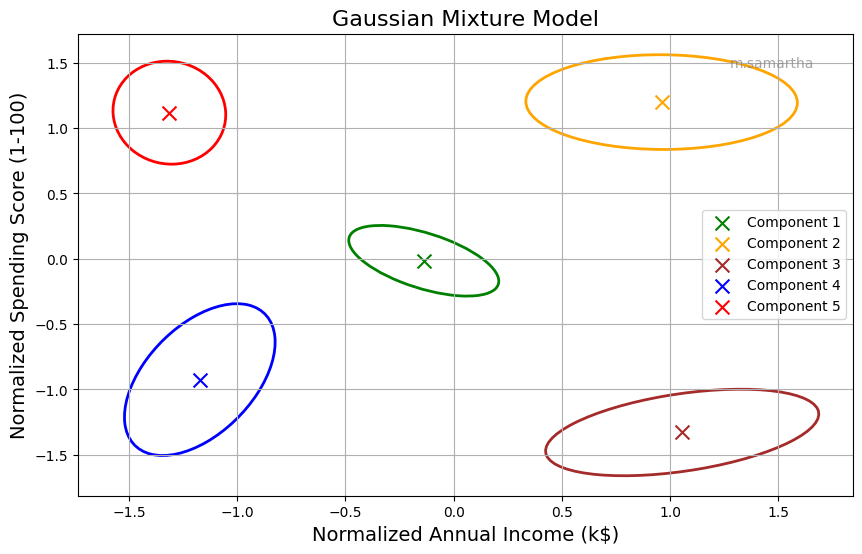

In [6]:
# Select features for clustering
X = df[["Annual Income (k$)", "Spending Score (1-100)"]].values   # numpy array

# Standardize features for fair comparison
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

gmm = GMM(n_components=5, max_iters=100, tol=1e-6, random_state=seed)
gmm.fit(X_scaled)
responsibilities = gmm.getMembership(X_scaled)
likelihoods = gmm.getLikelihood()
gmm.drawLikelihood()

df["Cluster"] = np.argmax(responsibilities, axis=1)
df.head()

colors = ['green','orange','brown','blue','red']

plt.figure(figsize=(10,6))
plt.title("Ploting the data into 5 clusters", fontsize=16)
sns.scatterplot(
    data=df, 
    x="Annual Income (k$)", 
    y="Spending Score (1-100)", 
    hue="Cluster",  
    palette=['green','orange','brown','blue','red'],
    legend='full'
)

centroids = scaler.inverse_transform(gmm.means)
plt.scatter(
    centroids[:, 0], 
    centroids[:, 1],   
    marker='X', 
    s=200, 
    c='black', 
    edgecolor='yellow',
    linewidths=2,
    label='Centroids'
)
plt.legend()

plt.text(
    0.95, 0.95, "m.samartha",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize=10, color='gray', alpha=0.7
)
plt.xlabel("Annual Income (k$)", fontsize=14)
plt.ylabel("Spending Score (1-100)", fontsize=14)
plt.show()

# Plot each Gaussian component
fig, ax = plt.subplots(figsize=(10, 6))
for i, (mean, cov) in enumerate(zip(gmm.means, gmm.covariances)):
    # Plot mean
    ax.scatter(mean[0], mean[1], c=[colors[i]], s=100, marker="x", label=f"Component {i+1}")

    # Eigen-decomposition of covariance
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # Compute angle in degrees
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Width and height of ellipse (scaled by sqrt of eigenvalues)
    width, height = 2 * np.sqrt(eigvals)

    # Draw ellipse
    ellipse = Ellipse(
        xy=mean,
        width=width,
        height=height,
        angle=angle,
        edgecolor=colors[i],
        facecolor="none",
        lw=2
    )
    ax.add_patch(ellipse)

ax.set_title("Gaussian Mixture Model", fontsize=16)
ax.set_xlabel("Normalized Annual Income (k$)", fontsize=14)
ax.set_ylabel("Normalized Spending Score (1-100)", fontsize=14)
ax.legend()
ax.text(
    0.95, 0.95, "m.samartha",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize=10, color='gray', alpha=0.7
)
ax.grid(True)
plt.show()

## 3.2 Determine the Optimal Number of Clusters

### BIC (Bayesian Information Criterion)

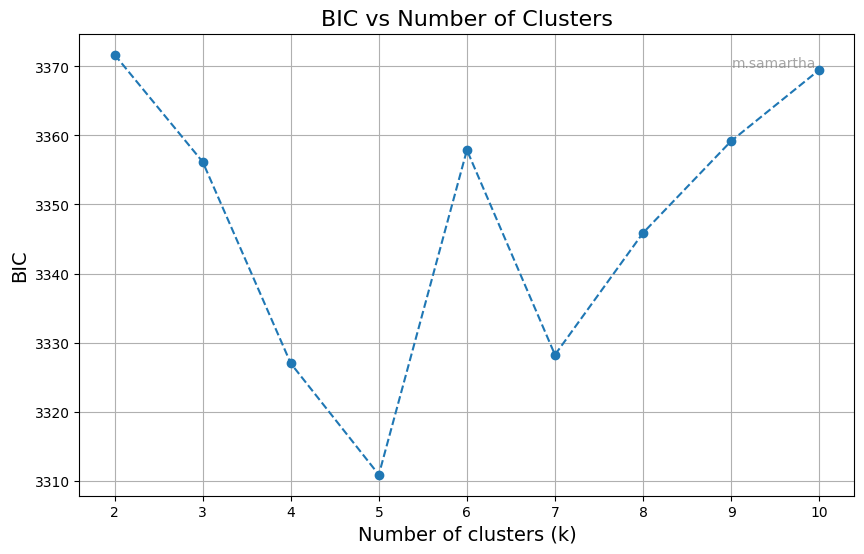

In [7]:
def compute_bic(log_likelihood, n_samples, n_components, n_features):
    """
    Compute Bayesian Information Criterion (BIC) for a fitted GMM.

    log_likelihood : float
        Log-likelihood of the model given the data.
    n_samples : int
        Number of data samples.
    n_components : int
        Number of Gaussian components in the GMM.
    n_features : int
        Number of features in the dataset.
    
    Returns
    -------
    bic : float
        The BIC score (lower is better).
    """
    # number of parameters
    n_params = (
        n_components * n_features                # means
        + n_components * (n_features * (n_features + 1)) / 2  # covariances
        + (n_components - 1)                     # weights
    )
    
    bic = n_params * np.log(n_samples) - 2 * log_likelihood
    return bic

k_range=range(2, 11)     
bic_scores = []


for k in k_range:
    gmm = GMM(n_components=k, random_state=seed)
    gmm.fit(X)
    ll = gmm.compute_likelihood(X)
    bic_score = compute_bic(ll, X.shape[0], k, X.shape[1])
    bic_scores.append(bic_score)

# Plot BIC
plt.figure(figsize=(10, 6))
plt.plot(list(k_range), bic_scores, marker='o', linestyle='--')
plt.xlabel("Number of clusters (k)", fontsize=14)
plt.ylabel("BIC", fontsize=14)
plt.title("BIC vs Number of Clusters", fontsize=16)
plt.grid(True)
plt.text(
    0.95, 0.95, "m.samartha",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize=10, color='gray', alpha=0.7
)
plt.show()

#### Observations from BIC plot
We observe that the BIC score decreases as the number of clusters increases, which is expected since more complex models tend to fit the data better. However after k=5, the BIC score starts to increase again, because of the penalty for model complexity. Therefore, the optimal number of clusters according to BIC is 5. BIC tends to prefer simpler models, thus it means that 5 clusters provide a good balance between model fit and complexity.

### Silhouette Method

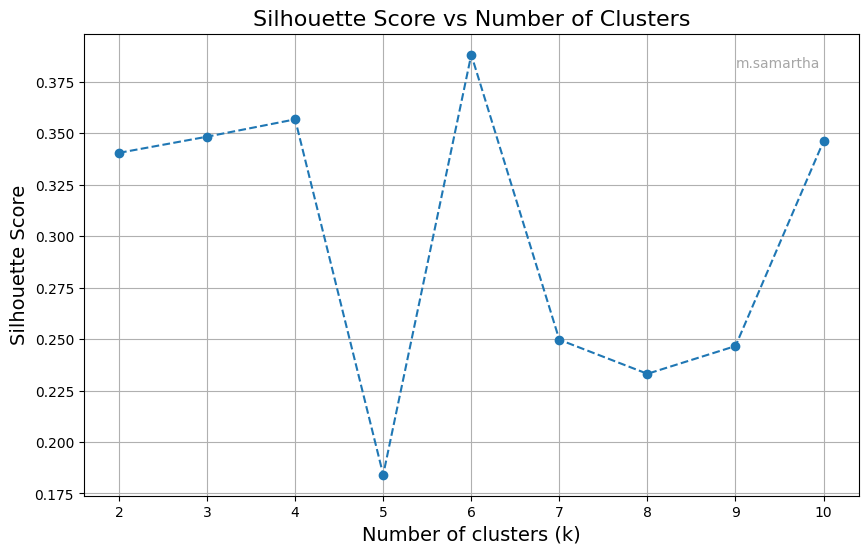

In [8]:
silhouette_scores = []
k_range=range(2, 11) 

for k in k_range:
    gmm = GMM(n_components=k, random_state=seed)
    gmm.fit(X)
    responsibilities = gmm.getMembership(X)
    hard_labels = np.argmax(responsibilities, axis=1)
    sil_score = silhouette_score(X, hard_labels, random_state=seed)
    silhouette_scores.append(sil_score)

# Plot Silhouette
plt.figure(figsize=(10, 6))
plt.plot(list(k_range), silhouette_scores, marker='o', linestyle='--')
plt.xlabel("Number of clusters (k)", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.title("Silhouette Score vs Number of Clusters", fontsize=16)
plt.grid(True)
plt.text(
    0.95, 0.95, "m.samartha",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize=10, color='gray', alpha=0.7
)
plt.show()

#### Observations from Silhouette plot
The silhouette scores peak at k=6, indicating that this number of clusters provides the best-defined and most cohesive clusters. A higher silhouette score suggests that the clusters are well-separated and that data points are closer to their own cluster center than to other cluster centers. Silhouette method focuses more on the cohesion and separation of clusters than the model complexity, hence it suggests 6 clusters as optimal. 

Both of these methods provide k = 5, 6 as the optimal number of clusters respectively, which is quite close to each other. Depending on the specific application and the importance of model simplicity versus cluster cohesion, one might choose either 5 or 6 clusters for further analysis.